In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)

In [2]:
# Load Arabic dataset
X_train_arabic = pd.read_csv(r"/kaggle/input/ahcd1/csvTrainImages 13440x1024.csv", header=None)
Y_train_arabic = pd.read_csv(r"/kaggle/input/ahcd1/csvTrainLabel 13440x1.csv", header=None)
X_test_arabic  = pd.read_csv(r"/kaggle/input/ahcd1/csvTestImages 3360x1024.csv", header=None)
Y_test_arabic  = pd.read_csv(r"/kaggle/input/ahcd1/csvTestLabel 3360x1.csv", header=None)

# Check the shapes of the datasets
print("Arabic Dataset Shapes:")
print("X_train_arabic:", X_train_arabic.shape)
print("X_test_arabic:", X_test_arabic.shape)
print("Y_train_arabic:", Y_train_arabic.shape)
print("Y_test_arabic:", Y_test_arabic.shape)

Arabic Dataset Shapes:
X_train_arabic: (13440, 1024)
X_test_arabic: (3360, 1024)
Y_train_arabic: (13440, 1)
Y_test_arabic: (3360, 1)


In [3]:
# Load English dataset (ubyte)
import struct

def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

# Paths
train_images_path = r"/kaggle/input/emnist/emnist_source_files/emnist-letters-train-images-idx3-ubyte"
train_labels_path = r"/kaggle/input/emnist/emnist_source_files/emnist-letters-train-labels-idx1-ubyte"
test_images_path  = r"/kaggle/input/emnist/emnist_source_files/emnist-letters-test-images-idx3-ubyte"
test_labels_path  = r"/kaggle/input/emnist/emnist_source_files/emnist-letters-test-labels-idx1-ubyte"

# Read images and labels
x_train_english = read_idx(train_images_path)
x_test_english  = read_idx(test_images_path)
y_train_english = read_idx(train_labels_path)
y_test_english  = read_idx(test_labels_path)

print("\nOriginal English Dataset Shapes:")
print("x_train_english:", x_train_english.shape)
print("y_train_english:", y_train_english.shape)
print("x_test_english:", x_test_english.shape)
print("y_test_english:", y_test_english.shape)


Original English Dataset Shapes:
x_train_english: (124800, 28, 28)
y_train_english: (124800,)
x_test_english: (20800, 28, 28)
y_test_english: (20800,)


In [4]:
def preprocess_images_pytorch(X, original_size=(32, 32), target_size=(96, 96), needs_reshape=False):

    print(f"Preprocessing images from {original_size} to {target_size}...")
    
    # Convert DataFrame to numpy if needed
    if not isinstance(X, np.ndarray):
        print(f"  Converting DataFrame to numpy array...")
        X = X.values
    
    N = X.shape[0]
    
    # Step 1: Reshape to (N, H, W) if needed
    if needs_reshape:
        print(f"  Reshaping from ({N}, {X.shape[1]}) to ({N}, {original_size[0]}, {original_size[1]})")
        X = X.reshape(-1, original_size[0], original_size[1])
    
    # Convert to uint8 (0-255 range) if not already
    if X.dtype != np.uint8:
        print(f"  Converting from {X.dtype} to uint8...")
        X = np.clip(X, 0, 255).astype(np.uint8)
    
    # Step 2: Resize to 96x96 using OpenCV
    X_resized = np.zeros((N, target_size[0], target_size[1]), dtype=np.uint8)
    for i in tqdm(range(N), desc="Resizing images", ncols=100):
        img = X[i].astype(np.uint8)  # Ensure uint8
        img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)
        X_resized[i] = img_resized
    
    # Step 3: Convert grayscale to RGB
    X_rgb = np.stack([X_resized, X_resized, X_resized], axis=-1)  # Shape: (N, 96, 96, 3)
    
    # Step 4: Rotate -90° and flip left-right (for Arabic orientation correction)
    print("  Applying rotation and flip...")
    for i in range(N):
        img = X_rgb[i]
        img = np.rot90(img, k=-1)  # Rotate -90°
        img = np.fliplr(img)       # Flip left-right
        X_rgb[i] = img
    
    print(f"✓ Preprocessing complete: {X_rgb.shape}")
    return X_rgb




In [5]:
# Preprocess Arabic data (32x32 flattened to 1024)
print("\nPreprocessing Arabic dataset...")
print(f"Input shape: {X_train_arabic.shape} (flattened 32×32 images)")
X_train_arabic_processed = preprocess_images_pytorch(
    X_train_arabic, 
    original_size=(32, 32), 
    target_size=(96, 96),
    needs_reshape=True  # Arabic data is flattened
)
X_test_arabic_processed = preprocess_images_pytorch(
    X_test_arabic, 
    original_size=(32, 32), 
    target_size=(96, 96),
    needs_reshape=True
)

# Preprocess English data (28x28 already 2D)
print("\nPreprocessing English dataset...")
print(f"Input shape: {x_train_english.shape} (already 2D 28×28 images)")
x_train_english_processed = preprocess_images_pytorch(
    x_train_english, 
    original_size=(28, 28), 
    target_size=(96, 96),
    needs_reshape=False  # English data is already 2D
)
x_test_english_processed = preprocess_images_pytorch(
    x_test_english, 
    original_size=(28, 28), 
    target_size=(96, 96),
    needs_reshape=False
)

# Remap English labels from 1-26 to 29-54
y_train_english_remapped = y_train_english + 28
y_test_english_remapped = y_test_english + 28
print(f"English labels remapped: {y_train_english_remapped.min()} to {y_train_english_remapped.max()}")

# Convert Arabic labels to numpy arrays and flatten
if not isinstance(Y_train_arabic, np.ndarray):
    Y_train_arabic = Y_train_arabic.values
if not isinstance(Y_test_arabic, np.ndarray):
    Y_test_arabic = Y_test_arabic.values

# Flatten if needed
if Y_train_arabic.ndim > 1:
    Y_train_arabic = Y_train_arabic.flatten()
if Y_test_arabic.ndim > 1:
    Y_test_arabic = Y_test_arabic.flatten()

X_train_combined = np.concatenate([X_train_arabic_processed, x_train_english_processed], axis=0)
Y_train_combined = np.concatenate([Y_train_arabic, y_train_english_remapped], axis=0)
X_test_combined = np.concatenate([X_test_arabic_processed, x_test_english_processed], axis=0)
Y_test_combined = np.concatenate([Y_test_arabic, y_test_english_remapped], axis=0)

print(f"\n Combined dataset shapes (before balancing):")
print(f"X_train: {X_train_combined.shape}")
print(f"Y_train: {Y_train_combined.shape} (labels range: {Y_train_combined.min()}-{Y_train_combined.max()})")
print(f"X_test: {X_test_combined.shape}")
print(f"Y_test: {Y_test_combined.shape} (labels range: {Y_test_combined.min()}-{Y_test_combined.max()})")

# Check class distribution before balancing
unique_train, counts_train = np.unique(Y_train_combined, return_counts=True)
print(f"\n  Training samples per class (before balancing):")
print(f"Min: {counts_train.min()} samples")
print(f"Max: {counts_train.max()} samples")
print(f"Mean: {counts_train.mean():.0f} samples")




STEP 1: PREPROCESSING DATA

Preprocessing Arabic dataset...
Input shape: (13440, 1024) (flattened 32×32 images)
Preprocessing images from (32, 32) to (96, 96)...
  Converting DataFrame to numpy array...
  Reshaping from (13440, 1024) to (13440, 32, 32)
  Converting from int64 to uint8...


Resizing images: 100%|█████████████████████████████████████| 13440/13440 [00:00<00:00, 43676.11it/s]


  Applying rotation and flip...
✓ Preprocessing complete: (13440, 96, 96, 3)
Preprocessing images from (32, 32) to (96, 96)...
  Converting DataFrame to numpy array...
  Reshaping from (3360, 1024) to (3360, 32, 32)
  Converting from int64 to uint8...


Resizing images: 100%|███████████████████████████████████████| 3360/3360 [00:00<00:00, 47300.05it/s]

  Applying rotation and flip...


✓ Preprocessing complete: (3360, 96, 96, 3)

Preprocessing English dataset...
Input shape: (124800, 28, 28) (already 2D 28×28 images)
Preprocessing images from (28, 28) to (96, 96)...


Resizing images: 100%|███████████████████████████████████| 124800/124800 [00:02<00:00, 53795.66it/s]


  Applying rotation and flip...
✓ Preprocessing complete: (124800, 96, 96, 3)
Preprocessing images from (28, 28) to (96, 96)...


Resizing images: 100%|█████████████████████████████████████| 20800/20800 [00:00<00:00, 53558.42it/s]


  Applying rotation and flip...
✓ Preprocessing complete: (20800, 96, 96, 3)

Remapping English labels from 1-26 to 29-54...
✓ English labels remapped: 29 to 54

Combining Arabic and English datasets...

✓ Combined dataset shapes (before balancing):
  X_train: (138240, 96, 96, 3)
  Y_train: (138240,) (labels range: 1-54)
  X_test: (24160, 96, 96, 3)
  Y_test: (24160,) (labels range: 1-54)

  Training samples per class (before balancing):
    Min: 480 samples
    Max: 4800 samples
    Mean: 2560 samples


In [6]:
# ===================== BALANCE COMBINED DATASET =======================
print("\n" + "=" * 70)
print("BALANCING COMBINED DATASET")
print("=" * 70)

def balance_dataset(images, labels, samples_per_class, random_state=42):
    """
    Balance dataset to have exactly samples_per_class for each class.
    
    Args:
        images: numpy array of images (N, H, W, C)
        labels: numpy array of labels (N,)
        samples_per_class: number of samples to keep per class
        random_state: random seed for reproducibility
    
    Returns:
        balanced_images, balanced_labels
    """
    np.random.seed(random_state)
    
    unique_classes = np.unique(labels)
    balanced_images = []
    balanced_labels = []
    
    print(f"Balancing {len(unique_classes)} classes to {samples_per_class} samples each...")
    
    for class_label in tqdm(unique_classes, desc="Balancing classes", ncols=100):
        # Get indices for this class
        class_indices = np.where(labels == class_label)[0]
        
        # Sample or replicate to get exactly samples_per_class
        if len(class_indices) >= samples_per_class:
            # If we have enough samples, randomly select
            selected_indices = np.random.choice(class_indices, size=samples_per_class, replace=False)
        else:
            # If we don't have enough, sample with replacement
            selected_indices = np.random.choice(class_indices, size=samples_per_class, replace=True)
        
        balanced_images.append(images[selected_indices])
        balanced_labels.append(labels[selected_indices])
    
    # Concatenate all classes
    balanced_images = np.concatenate(balanced_images, axis=0)
    balanced_labels = np.concatenate(balanced_labels, axis=0)
    
    # Shuffle the balanced dataset
    shuffle_indices = np.random.permutation(len(balanced_labels))
    balanced_images = balanced_images[shuffle_indices]
    balanced_labels = balanced_labels[shuffle_indices]
    
    return balanced_images, balanced_labels

# Balance training set: 480 samples per class (54 classes)
X_train_balanced, Y_train_balanced = balance_dataset(
    X_train_combined, 
    Y_train_combined, 
    samples_per_class=480, 
    random_state=42
)

# Balance test set: 120 samples per class (54 classes)
X_test_balanced, Y_test_balanced = balance_dataset(
    X_test_combined, 
    Y_test_combined, 
    samples_per_class=120, 
    random_state=42
)

print(f"\n✓ Balanced dataset shapes:")
print(f"  X_train: {X_train_balanced.shape}")
print(f"  Y_train: {Y_train_balanced.shape}")
print(f"  X_test: {X_test_balanced.shape}")
print(f"  Y_test: {Y_test_balanced.shape}")

# Verify balance
unique_train_bal, counts_train_bal = np.unique(Y_train_balanced, return_counts=True)
unique_test_bal, counts_test_bal = np.unique(Y_test_balanced, return_counts=True)

print(f"\n✓ Verification:")
print(f"  Training set:")
print(f"    - Total samples: {len(Y_train_balanced)} (54 classes × 480 = 25,920)")
print(f"    - Samples per class: {counts_train_bal[0]} (all classes equal)")
print(f"  Test set:")
print(f"    - Total samples: {len(Y_test_balanced)} (54 classes × 120 = 6,480)")
print(f"    - Samples per class: {counts_test_bal[0]} (all classes equal)")

# Use balanced datasets for further processing
X_train_combined = X_train_balanced
Y_train_combined = Y_train_balanced
X_test_combined = X_test_balanced
Y_test_combined = Y_test_balanced




BALANCING COMBINED DATASET
Balancing 54 classes to 480 samples each...


Balancing classes: 100%|███████████████████████████████████████████| 54/54 [00:00<00:00, 203.26it/s]


Balancing 54 classes to 120 samples each...


Balancing classes: 100%|███████████████████████████████████████████| 54/54 [00:00<00:00, 647.69it/s]


✓ Balanced dataset shapes:
  X_train: (25920, 96, 96, 3)
  Y_train: (25920,)
  X_test: (6480, 96, 96, 3)
  Y_test: (6480,)

✓ Verification:
  Training set:
    - Total samples: 25920 (54 classes × 480 = 25,920)
    - Samples per class: 480 (all classes equal)
  Test set:
    - Total samples: 6480 (54 classes × 120 = 6,480)
    - Samples per class: 120 (all classes equal)


In [7]:
def augment_dataset(images, labels, n_augmentations=2):
    from scipy.ndimage import rotate, shift
    from skimage.transform import AffineTransform, warp
    
    N = len(images)
    all_images = [images]  # Start with original images
    all_labels = [labels]
    
    for aug_idx in range(n_augmentations):
        print(f"\nGenerating augmentation set {aug_idx+1}/{n_augmentations}...")
        augmented = np.zeros_like(images)
        
        for i in tqdm(range(N), desc=f"Augmentation {aug_idx+1}"):
            img = images[i].astype(np.float32)
            
            # Random rotation (-15 to +15 degrees)
            angle = np.random.uniform(-15, 15)
            img = rotate(img, angle, axes=(0, 1), reshape=False, mode='nearest')
            
            # Random translation
            shift_y = np.random.uniform(-0.1, 0.1) * 96
            shift_x = np.random.uniform(-0.1, 0.1) * 96
            img = shift(img, [shift_y, shift_x, 0], mode='nearest')
            
            # Random brightness
            brightness_factor = np.random.uniform(0.85, 1.15)
            img = np.clip(img * brightness_factor, 0, 255)
            
            # Add Gaussian noise
            noise = np.random.normal(0, 10, img.shape)
            img = np.clip(img + noise, 0, 255)
            
            augmented[i] = img.astype(np.uint8)
        
        all_images.append(augmented)
        all_labels.append(labels)
    
    # Concatenate all (original + augmented)
    final_images = np.concatenate(all_images, axis=0)
    final_labels = np.concatenate(all_labels, axis=0)
    
    print(f"\nDataset expanded from {N} to {len(final_images)} samples")
    return final_images, final_labels

# Augment training data (create 2 augmented copies + 1 original = 3x size)
print("\nAugmenting training data...")
X_train_augmented, Y_train_augmented = augment_dataset(
    X_train_combined, 
    Y_train_combined, 
    n_augmentations=2  # Creates 3x more data
)

print(f"\nFinal training set size: {X_train_augmented.shape[0]} samples")
print(f"Test set size: {X_test_combined.shape[0]} samples")



STEP 2: DATA AUGMENTATION (Expanding Dataset)

Augmenting training data...

Generating augmentation set 1/2...


Augmentation 1: 100%|██████████| 25920/25920 [11:20<00:00, 38.08it/s]



Generating augmentation set 2/2...


Augmentation 2: 100%|██████████| 25920/25920 [11:20<00:00, 38.10it/s]



✓ Dataset expanded from 25920 to 77760 samples

Final training set size: 77760 samples
Test set size: 6480 samples


In [8]:
X_train_split, X_val_split, Y_train_split, Y_val_split = train_test_split(
    X_train_augmented, Y_train_augmented,
    test_size=0.15,
    random_state=42,
    stratify=Y_train_augmented
)

print(f"Train set: {X_train_split.shape[0]} samples")
print(f"Validation set: {X_val_split.shape[0]} samples")
print(f"Test set: {X_test_combined.shape[0]} samples")


STEP 3: TRAIN/VALIDATION SPLIT
Train set: 66096 samples
Validation set: 11664 samples
Test set: 6480 samples


In [9]:
class ArabicEnglishDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels - 1  # Convert 1-54 to 0-53
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].astype(np.float32) / 255.0
        label = self.labels[idx]
        
        # Convert to tensor (C, H, W)
        image = torch.from_numpy(image).permute(2, 0, 1)
        
        if self.transform:
            image = self.transform(image)
            
        return image, label



In [10]:
# ===================== DATA TRANSFORMS =======================
# Minimal augmentation since we already augmented offline
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



In [11]:
train_dataset = ArabicEnglishDataset(X_train_split, Y_train_split, transform=train_transform)
val_dataset = ArabicEnglishDataset(X_val_split, Y_val_split, transform=test_transform)
test_dataset = ArabicEnglishDataset(X_test_combined, Y_test_combined, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

print(f"Train batches: {len(train_loader)} (batch_size=64)")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")





STEP 4: CREATING DATALOADERS
Train batches: 1033 (batch_size=64)
Val batches: 183
Test batches: 102


In [12]:
num_classes = 54
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1, aux_logits=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace final layers
model.fc = nn.Linear(model.fc.in_features, num_classes)
if hasattr(model, 'aux1'):
    model.aux1.fc2 = nn.Linear(model.aux1.fc2.in_features, num_classes)
if hasattr(model, 'aux2'):
    model.aux2.fc2 = nn.Linear(model.aux2.fc2.in_features, num_classes)

model = model.to(device)




STEP 5: MODEL SETUP
Using device: cuda


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 163MB/s] 
/usr/local/lib/python3.11/dist-packages/torchvision/models/googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn(


In [13]:
# ===================== TRAINING SETUP =======================
criterion = nn.CrossEntropyLoss()
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(trainable_params, lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

print(f"Trainable parameters: {sum(p.numel() for p in trainable_params):,}")



Trainable parameters: 166,050


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [14]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        if model.training and model.aux_logits:
            outputs, aux2, aux1 = model(images)
            loss1 = criterion(outputs, labels)
            loss2 = criterion(aux2, labels)
            loss3 = criterion(aux1, labels)
            loss = loss1 + 0.3 * loss2 + 0.3 * loss3
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({'loss': running_loss/(pbar.n+1), 'acc': 100.*correct/total})
    
    return running_loss/len(loader), 100.*correct/total

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            pbar.set_postfix({'loss': running_loss/(pbar.n+1), 'acc': 100.*correct/total})
    
    return running_loss/len(loader), 100.*correct/total



In [15]:
num_epochs = 20
train_losses, train_accs = [], []
val_losses, val_accs = [], []
best_val_acc = 0.0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    scheduler.step(val_acc)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_googlenet_arabic_english.pth')
        print(f"Saved best model with val acc: {best_val_acc:.2f}%")




STEP 6: TRAINING

Epoch 1/20


Validation: 100%|██████████| 183/183 [00:03<00:00, 54.48it/s, loss=1.43, acc=59.3]


Train Loss: 3.4057, Train Acc: 47.40%
Val Loss: 1.4245, Val Acc: 59.27%
✓ Saved best model with val acc: 59.27%

Epoch 2/20


Validation: 100%|██████████| 183/183 [00:03<00:00, 54.54it/s, loss=1.32, acc=62.2]


Train Loss: 2.6197, Train Acc: 57.02%
Val Loss: 1.2764, Val Acc: 62.21%
✓ Saved best model with val acc: 62.21%

Epoch 3/20


Validation: 100%|██████████| 183/183 [00:03<00:00, 52.66it/s, loss=1.21, acc=64]  


Train Loss: 2.5014, Train Acc: 58.82%
Val Loss: 1.2074, Val Acc: 63.98%
✓ Saved best model with val acc: 63.98%

Epoch 4/20


Validation: 100%|██████████| 183/183 [00:03<00:00, 52.14it/s, loss=1.2, acc=64.1] 


Train Loss: 2.4454, Train Acc: 59.88%
Val Loss: 1.1932, Val Acc: 64.06%
✓ Saved best model with val acc: 64.06%

Epoch 5/20


Validation: 100%|██████████| 183/183 [00:03<00:00, 53.12it/s, loss=1.18, acc=64.9]


Train Loss: 2.4245, Train Acc: 59.96%
Val Loss: 1.1769, Val Acc: 64.86%
✓ Saved best model with val acc: 64.86%

Epoch 6/20


Validation: 100%|██████████| 183/183 [00:03<00:00, 53.57it/s, loss=1.19, acc=64.5]


Train Loss: 2.3990, Train Acc: 60.71%
Val Loss: 1.1578, Val Acc: 64.46%

Epoch 7/20


Validation: 100%|██████████| 183/183 [00:03<00:00, 50.90it/s, loss=1.16, acc=64.9]


Train Loss: 2.3945, Train Acc: 60.78%
Val Loss: 1.1519, Val Acc: 64.91%
✓ Saved best model with val acc: 64.91%

Epoch 8/20


Validation: 100%|██████████| 183/183 [00:03<00:00, 53.36it/s, loss=1.15, acc=65]  


Train Loss: 2.3904, Train Acc: 60.65%
Val Loss: 1.1461, Val Acc: 65.01%
✓ Saved best model with val acc: 65.01%

Epoch 9/20


Validation: 100%|██████████| 183/183 [00:03<00:00, 53.13it/s, loss=1.13, acc=65.9]


Train Loss: 2.3772, Train Acc: 60.94%
Val Loss: 1.1196, Val Acc: 65.91%
✓ Saved best model with val acc: 65.91%

Epoch 10/20


Validation: 100%|██████████| 183/183 [00:03<00:00, 51.58it/s, loss=1.15, acc=65]  


Train Loss: 2.3769, Train Acc: 60.73%
Val Loss: 1.1456, Val Acc: 64.97%

Epoch 11/20


Validation: 100%|██████████| 183/183 [00:03<00:00, 52.69it/s, loss=1.12, acc=66]  


Train Loss: 2.3693, Train Acc: 61.11%
Val Loss: 1.1195, Val Acc: 65.98%
✓ Saved best model with val acc: 65.98%

Epoch 12/20


Validation: 100%|██████████| 183/183 [00:03<00:00, 53.05it/s, loss=1.14, acc=65.8]


Train Loss: 2.3704, Train Acc: 60.80%
Val Loss: 1.1352, Val Acc: 65.76%

Epoch 13/20


Validation: 100%|██████████| 183/183 [00:03<00:00, 51.63it/s, loss=1.13, acc=65.6]


Train Loss: 2.3695, Train Acc: 61.06%
Val Loss: 1.1194, Val Acc: 65.64%

Epoch 14/20


Validation: 100%|██████████| 183/183 [00:03<00:00, 53.10it/s, loss=1.12, acc=66.1]


Train Loss: 2.3652, Train Acc: 61.06%
Val Loss: 1.1147, Val Acc: 66.14%
✓ Saved best model with val acc: 66.14%

Epoch 15/20


Validation: 100%|██████████| 183/183 [00:03<00:00, 53.35it/s, loss=1.13, acc=65.7]


Train Loss: 2.3632, Train Acc: 61.05%
Val Loss: 1.1276, Val Acc: 65.66%

Epoch 16/20


Validation: 100%|██████████| 183/183 [00:03<00:00, 51.65it/s, loss=1.13, acc=66.2]


Train Loss: 2.3613, Train Acc: 61.33%
Val Loss: 1.1149, Val Acc: 66.17%
✓ Saved best model with val acc: 66.17%

Epoch 17/20


Validation: 100%|██████████| 183/183 [00:03<00:00, 53.46it/s, loss=1.13, acc=65.2]


Train Loss: 2.3535, Train Acc: 61.27%
Val Loss: 1.1285, Val Acc: 65.23%

Epoch 18/20


Validation: 100%|██████████| 183/183 [00:03<00:00, 53.32it/s, loss=1.12, acc=65.6]


Train Loss: 2.3551, Train Acc: 61.34%
Val Loss: 1.1159, Val Acc: 65.58%

Epoch 19/20


Validation: 100%|██████████| 183/183 [00:03<00:00, 52.77it/s, loss=1.1, acc=66.5] 


Train Loss: 2.3614, Train Acc: 61.27%
Val Loss: 1.1014, Val Acc: 66.50%
✓ Saved best model with val acc: 66.50%

Epoch 20/20


Validation: 100%|██████████| 183/183 [00:03<00:00, 52.10it/s, loss=1.12, acc=66.1]

Train Loss: 2.3596, Train Acc: 61.34%
Val Loss: 1.1158, Val Acc: 66.06%

TRAINING COMPLETE - Best Val Accuracy: 66.50%


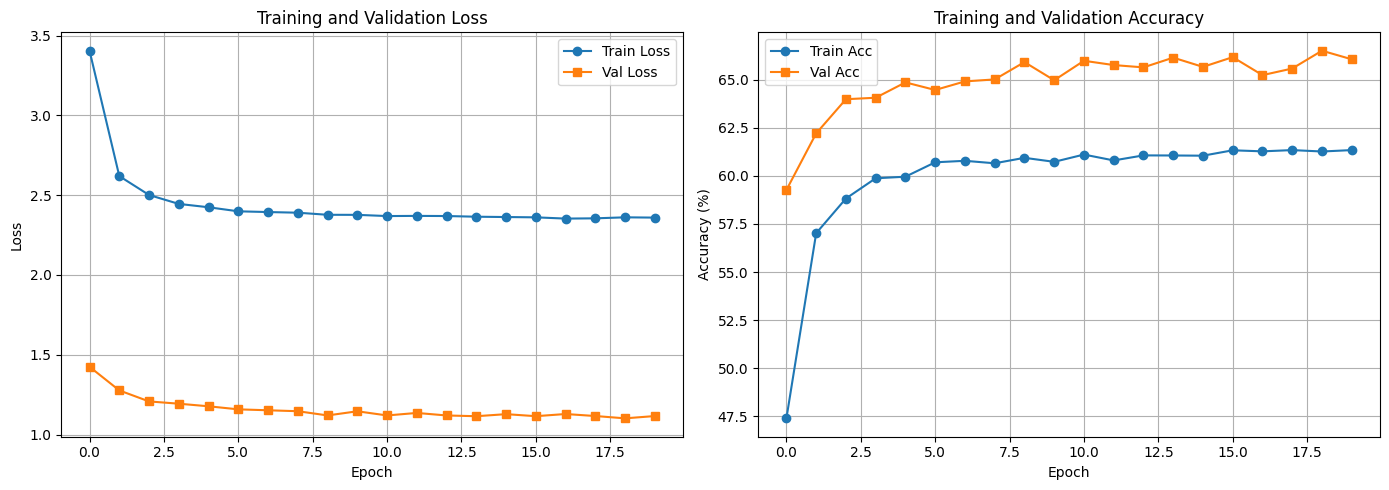

In [16]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(train_losses, label='Train Loss', marker='o')
ax1.plot(val_losses, label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(train_accs, label='Train Acc', marker='o')
ax2.plot(val_accs, label='Val Acc', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()



In [17]:
# ===================== FINAL TEST EVALUATION =======================
print("\n" + "=" * 70)
print("FINAL TEST EVALUATION (UNSEEN DATA)")
print("=" * 70)

model.load_state_dict(torch.load('best_googlenet_arabic_english.pth'))
test_loss, test_acc = validate(model, test_loader, criterion, device)

print(f"\n{'='*70}")
print(f"FINAL RESULTS:")
print(f"{'='*70}")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"Final Test Accuracy:      {test_acc:.2f}%")
print(f"Test Loss:                {test_loss:.4f}")
print(f"{'='*70}")


FINAL TEST EVALUATION (UNSEEN DATA)


Validation: 100%|██████████| 102/102 [00:02<00:00, 49.83it/s, loss=0.907, acc=74.2]


FINAL RESULTS:
Best Validation Accuracy: 66.50%
Final Test Accuracy:      74.21%
Test Loss:                0.8628


In [ ]:
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)
from itertools import cycle
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# ROC & AUC
Y_test_bin = label_binarize(Y_test_sparse, classes=range(num_classes))

fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], Y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_bin.ravel(), Y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(16, 12))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC={roc_auc["micro"]:.3f})',
         color='deeppink', linestyle='--', linewidth=3)

colors = cycle([
    'aqua','darkorange','cornflowerblue','green','red','purple',
    'brown','pink','gray','olive','cyan','magenta','yellow',
    'navy','teal','lime','gold','indigo','coral','turquoise',
    'salmon','khaki','plum','tan','silver','crimson','orchid','wheat'
])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1, alpha=0.6,
             label=f'ROC {class_list[i]} (AUC={roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Arabic + English Characters')
plt.legend(loc="lower right", fontsize=8, ncol=2)
plt.grid(True, alpha=0.3)
plt.show()

# ROC & AUC
Y_test_bin = label_binarize(Y_test_sparse, classes=range(num_classes))

fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], Y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_bin.ravel(), Y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(16, 12))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC={roc_auc["micro"]:.3f})',
         color='deeppink', linestyle='--', linewidth=3)

colors = cycle(['aqua','darkorange','cornflowerblue','green','red','purple',
                'brown','pink','gray','olive','cyan','magenta','yellow',
                'navy','teal','lime','gold','indigo','coral','turquoise',
                'salmon','khaki','plum','tan','silver','crimson','orchid','wheat'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1, alpha=0.6,
             label=f'ROC {class_names[i]} (AUC={roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Arabic Characters')
plt.legend(loc="lower right", fontsize=8, ncol=2)
plt.grid(True, alpha=0.3)
plt.show()


In [18]:
class_mapping = {
    # Arabic (1-28)
    1: "أ", 2: "ب", 3: "ت", 4: "ث", 5: "ج", 6: "ح", 7: "خ", 8: "د", 9: "ذ", 10: "ر",
    11: "ز", 12: "س", 13: "ش", 14: "ص", 15: "ض", 16: "ط", 17: "ظ", 18: "ع", 19: "غ",
    20: "ف", 21: "ق", 22: "ك", 23: "ل", 24: "م", 25: "ن", 26: "هـ", 27: "و", 28: "ي",
    
    # English (29-54)
    29: "A", 30: "B", 31: "C", 32: "D", 33: "E", 34: "F", 35: "G", 36: "H", 37: "I", 38: "J",
    39: "K", 40: "L", 41: "M", 42: "N", 43: "O", 44: "P", 45: "Q", 46: "R", 47: "S", 48: "T",
    49: "U", 50: "V", 51: "W", 52: "X", 53: "Y", 54: "Z"
}

print(f"Total classes: {len(class_mapping)}")

Total classes: 54


In [ ]:
# ROC & AUC
Y_test_bin = label_binarize(Y_test, classes=range(num_classes))

fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], Y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_bin.ravel(), Y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(16, 12))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC={roc_auc["micro"]:.3f})',
         color='deeppink', linestyle='--', linewidth=3)

colors = cycle(['aqua','darkorange','cornflowerblue','green','red','purple',
                'brown','pink','gray','olive','cyan','magenta','yellow',
                'navy','teal','lime','gold','indigo','coral','turquoise',
                'salmon','khaki','plum','tan','silver','crimson','orchid','wheat'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1, alpha=0.6,
             label=f'ROC {class_names[i]} (AUC={roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Arabic Characters')
plt.legend(loc="lower right", fontsize=8, ncol=2)
plt.grid(True, alpha=0.3)
plt.show()



Generating prediction visualizations...


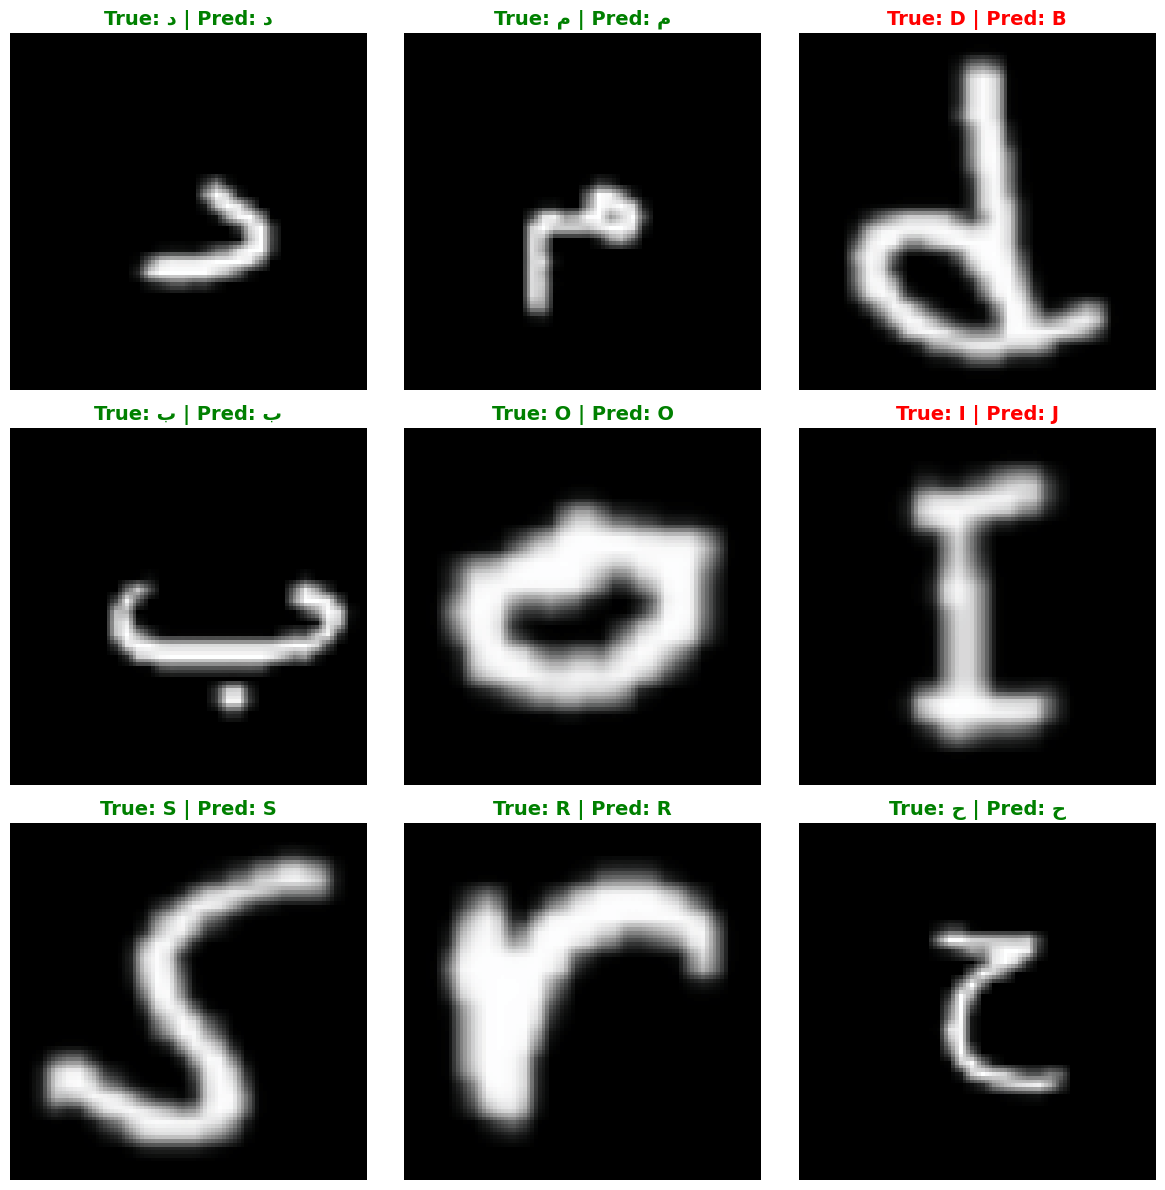

In [19]:
# ===================== VISUALIZE PREDICTIONS =======================
def visualize_predictions(model, loader, class_mapping, device, num_samples=9):
    model.eval()
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()
    
    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, predictions = outputs.max(1)
    
    for i in range(min(num_samples, len(images))):
        img = images[i].cpu().permute(1, 2, 0).numpy()
        
        # Denormalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = img * std + mean
        img = np.clip(img, 0, 1)
        
        true_label = labels[i].item() + 1
        pred_label = predictions[i].item() + 1
        
        true_char = class_mapping.get(true_label, str(true_label))
        pred_char = class_mapping.get(pred_label, str(pred_label))
        
        color = 'green' if true_label == pred_label else 'red'
        
        axes[i].imshow(img)
        axes[i].set_title(f'True: {true_char} | Pred: {pred_char}', 
                         color=color, fontsize=14, fontweight='bold')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

print("\nGenerating prediction visualizations...")
visualize_predictions(model, test_loader, class_mapping, device)

In [ ]:
from sklearn.metrics import classification_report

class_list = [
    "أ", "ب", "ت", "ث", "ج", "ح", "خ", "د", "ذ", "ر",
    "ز", "س", "ش", "ص", "ض", "ط", "ظ", "ع", "غ",
    "ف", "ق", "ك", "ل", "م", "ن", "هـ", "و", "ي",
    "A", "B", "C", "D", "E", "F", "G", "H", "I", "J",
    "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T",
    "U", "V", "W", "X", "Y", "Z"
]

# classification report
report = classification_report(Y_test_sparse, Y_pred, target_names=class_list)
print("CLASSIFICATION REPORT")
print("="*70)
print(report)


In [ ]:
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)
from itertools import cycle
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# ROC & AUC
Y_test_bin = label_binarize(Y_test_sparse, classes=range(num_classes))

fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], Y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_bin.ravel(), Y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(16, 12))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC={roc_auc["micro"]:.3f})',
         color='deeppink', linestyle='--', linewidth=3)

colors = cycle([
    'aqua','darkorange','cornflowerblue','green','red','purple',
    'brown','pink','gray','olive','cyan','magenta','yellow',
    'navy','teal','lime','gold','indigo','coral','turquoise',
    'salmon','khaki','plum','tan','silver','crimson','orchid','wheat'
])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1, alpha=0.6,
             label=f'ROC {class_list[i]} (AUC={roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Arabic + English Characters')
plt.legend(loc="lower right", fontsize=8, ncol=2)
plt.grid(True, alpha=0.3)
plt.show()

# ROC & AUC
Y_test_bin = label_binarize(Y_test_sparse, classes=range(num_classes))

fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], Y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_bin.ravel(), Y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(16, 12))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC={roc_auc["micro"]:.3f})',
         color='deeppink', linestyle='--', linewidth=3)

colors = cycle(['aqua','darkorange','cornflowerblue','green','red','purple',
                'brown','pink','gray','olive','cyan','magenta','yellow',
                'navy','teal','lime','gold','indigo','coral','turquoise',
                'salmon','khaki','plum','tan','silver','crimson','orchid','wheat'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1, alpha=0.6,
             label=f'ROC {class_names[i]} (AUC={roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Arabic Characters')
plt.legend(loc="lower right", fontsize=8, ncol=2)
plt.grid(True, alpha=0.3)
plt.show()
